In [1]:
#To do lambdaの外部入力
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
using Zygote
include("./src/Nevanlinna.jl")

Main.Nevanlinna

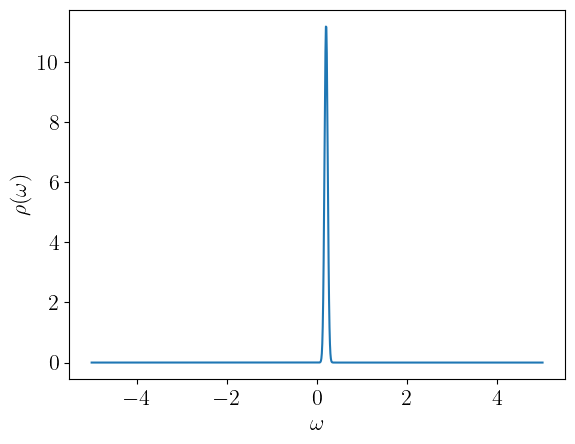

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbe1cb1e070>

In [2]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = gaussian(omega, 1.0, 0.15) +
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

#off-centered gaussian
rho(omega) = gaussian(omega, 0.2, 0.05) 

omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [4]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

71

In [5]:
setprecision(128)
;

In [6]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [7]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end

In [8]:
N_real    =  6000
omega_max =  10.0
eta       =  0.001
H         =  35
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 71
@time result    = Nevanlinna.Nevanlinna_Schur(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, true)
opt_real = result[2]
;

N_imag is setted as 10
Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     3.620234e+05     1.316870e+06
 * time: 0.027528047561645508
     1     3.257264e+05     1.736801e+06
 * time: 103.45541095733643
     2     3.163410e+05     5.088355e+05
 * time: 238.31755709648132
     3     3.033060e+05     2.555824e+05
 * time: 363.55225896835327
     4     2.778439e+05     1.856346e+05
 * time: 421.8943860530853
     5     2.619345e+05     1.517580e+05
 * time: 474.3637011051178
     6     2.134806e+05     9.852651e+04
 * time: 520.2071850299835
     7     1.702230e+05     2.394071e+05
 * time: 559.4458241462708
     8     1.339190e+05     1.716447e+05
 * time: 607.0819551944733
     9     8.846976e+04     1.514710e+05
 * time: 634.765557050705
    10     3.802681e+04     9.392034e+04
 * time: 685.8750970363617
    11     3.472302e+04     8.774275e+04
 * time: 719.2067251205444
    12     3.308954e+04     1.762004e+05
 * time: 760.8340799808502
    13  

   118     3.210174e+02     5.333724e+02
 * time: 1698.0853321552277
   119     3.205034e+02     4.291087e+02
 * time: 1702.6896350383759
   120     3.201541e+02     1.014775e+02
 * time: 1707.3630759716034
   121     3.200026e+02     1.715715e+02
 * time: 1714.4924421310425
   122     3.198368e+02     3.388793e+02
 * time: 1721.64994597435
   123     3.196854e+02     1.103093e+02
 * time: 1726.6041769981384
   124     3.194847e+02     4.269786e+02
 * time: 1731.0630559921265
   125     3.193482e+02     5.299407e+01
 * time: 1735.77019405365
   126     3.183518e+02     5.737422e+02
 * time: 1742.7247309684753
   127     3.182946e+02     4.951507e+02
 * time: 1752.1120150089264
   128     3.181134e+02     9.198711e+01
 * time: 1756.8238241672516
   129     3.179800e+02     2.274402e+02
 * time: 1761.487720966339
   130     3.176517e+02     1.863491e+02
 * time: 1779.816861152649
   131     3.176304e+02     1.282074e+02
 * time: 1788.9068920612335
   132     3.176105e+02     1.099751e+02

   238     2.999836e+02     4.780836e+02
 * time: 2387.2886831760406
   239     2.999539e+02     2.906078e+02
 * time: 2391.698310136795
   240     2.999207e+02     5.229182e+02
 * time: 2396.104135990143
   241     2.998865e+02     3.108798e+02
 * time: 2400.4931440353394
   242     2.998490e+02     5.639902e+02
 * time: 2405.1130921840668
   243     2.998119e+02     2.902363e+02
 * time: 2409.633054971695
   244     2.997703e+02     6.278884e+02
 * time: 2414.616583108902
   245     2.997310e+02     2.149366e+02
 * time: 2418.921792984009
   246     2.996796e+02     7.929175e+02
 * time: 2423.8576600551605
   247     2.996354e+02     1.537203e+01
 * time: 2428.89488697052
   248     2.992764e+02     2.514914e+03
 * time: 2435.994964122772
   249     2.990280e+02     1.226944e+02
 * time: 2443.050670146942
   250     2.975164e+02     3.442918e+03
 * time: 2452.3028881549835
   251     2.971745e+02     1.457471e+03
 * time: 2459.520527124405
   252     2.970955e+02     2.067221e+02
 * 

   358     2.942249e+02     9.666648e+01
 * time: 2999.6730620861053
   359     2.942230e+02     2.158726e+02
 * time: 3004.569717168808
   360     2.942210e+02     9.906349e+01
 * time: 3009.158117055893
   361     2.942191e+02     2.119384e+02
 * time: 3013.973654985428
   362     2.942171e+02     9.570629e+01
 * time: 3018.4456610679626
   363     2.942153e+02     2.091167e+02
 * time: 3023.146857023239
   364     2.942134e+02     9.007769e+01
 * time: 3027.5388391017914
   365     2.942116e+02     2.066132e+02
 * time: 3032.4156341552734
   366     2.942099e+02     8.650254e+01
 * time: 3037.4163930416107
   367     2.942081e+02     2.037552e+02
 * time: 3041.797996044159
   368     2.942064e+02     8.712451e+01
 * time: 3046.725921154022
   369     2.942047e+02     1.992521e+02
 * time: 3051.624386072159
   370     2.942030e+02     9.304112e+01
 * time: 3055.994441986084
   371     2.942013e+02     1.915112e+02
 * time: 3060.932361125946
   372     2.941995e+02     1.052358e+02
 *

   478     2.939901e+02     3.702418e+02
 * time: 3621.9544970989227
   479     2.939870e+02     6.528739e+01
 * time: 3626.960760116577
   480     2.939829e+02     4.566243e+02
 * time: 3631.8512840270996
   481     2.939789e+02     3.205852e+01
 * time: 3636.4831931591034
   482     2.939682e+02     8.006785e+02
 * time: 3641.322811126709
   483     2.939583e+02     6.008293e+01
 * time: 3646.079828977585
   484     2.939472e+02     7.890588e+02
 * time: 3653.3700201511383
   485     2.939368e+02     4.407525e+01
 * time: 3657.741693019867
   486     2.939301e+02     6.247587e+02
 * time: 3662.573143005371
   487     2.939238e+02     3.130991e+01
 * time: 3667.5208461284637
   488     2.938466e+02     1.528026e+03
 * time: 3676.788117170334
   489     2.938158e+02     4.963985e+01
 * time: 3686.1835610866547
   490     2.937865e+02     3.746589e+01
 * time: 3693.396768093109
   491     2.937820e+02     4.921592e+02
 * time: 3698.411484003067
   492     2.937780e+02     4.621636e+01
 

   598     2.914856e+02     7.561308e+01
 * time: 4353.398051023483
   599     2.914452e+02     1.657911e+03
 * time: 4358.22456407547
   600     2.914218e+02     3.011385e+02
 * time: 4363.137392044067
   601     2.913915e+02     5.030579e+02
 * time: 4370.297904968262
   602     2.913854e+02     3.278495e+02
 * time: 4375.14103603363
   603     2.913611e+02     3.197211e+02
 * time: 4382.420875072479
   604     2.913549e+02     3.005788e+02
 * time: 4386.8107171058655
   605     2.913418e+02     6.349782e+02
 * time: 4394.024765014648
   606     2.913319e+02     1.541874e+02
 * time: 4398.963346004486
   607     2.913236e+02     4.785511e+02
 * time: 4403.433436155319
   608     2.913173e+02     2.195270e+02
 * time: 4408.236049175262
   609     2.913112e+02     4.141894e+02
 * time: 4412.70005106926
   610     2.913057e+02     2.782163e+02
 * time: 4417.867485046387
   611     2.912997e+02     4.596390e+02
 * time: 4422.857864141464
   612     2.912939e+02     2.592463e+02
 * time: 

   719     2.894383e+02     5.690395e+02
 * time: 5002.163218975067
   720     2.894339e+02     3.674440e+02
 * time: 5006.795183181763
   721     2.894293e+02     6.068085e+02
 * time: 5011.227058172226
   722     2.894248e+02     3.390377e+02
 * time: 5015.745059967041
   723     2.894199e+02     6.566935e+02
 * time: 5020.048923969269
   724     2.894153e+02     2.991909e+02
 * time: 5025.000576972961
   725     2.894099e+02     7.478616e+02
 * time: 5029.986163139343
   726     2.894048e+02     2.403999e+02
 * time: 5034.5629279613495
   727     2.893974e+02     9.778576e+02
 * time: 5039.3363790512085
   728     2.893906e+02     1.229447e+02
 * time: 5044.092736005783
   729     2.893520e+02     2.557207e+03
 * time: 5051.3097150325775
   730     2.893193e+02     1.269566e+02
 * time: 5058.318202972412
   731     2.892658e+02     3.113552e+03
 * time: 5065.041543006897
   732     2.892196e+02     1.154948e+02
 * time: 5071.929066181183
   733     2.891588e+02     3.249878e+03
 * t

   840     2.871603e+02     2.484875e+03
 * time: 5650.966224193573
   841     2.871408e+02     1.908245e+02
 * time: 5655.833950996399
   842     2.871262e+02     1.961693e+03
 * time: 5660.444733142853
   843     2.871131e+02     3.182251e+01
 * time: 5664.986140012741
   844     2.870614e+02     3.086793e+03
 * time: 5672.046566963196
   845     2.870358e+02     2.912141e+02
 * time: 5676.901286125183
   846     2.870150e+02     8.614348e+02
 * time: 5683.489775180817
   847     2.870115e+02     2.095987e+02
 * time: 5688.086976051331
   848     2.870028e+02     1.075260e+03
 * time: 5695.100180149078
   849     2.869979e+02     2.100513e+02
 * time: 5700.070099115372
   850     2.869907e+02     1.172841e+03
 * time: 5707.299404144287
   851     2.869850e+02     2.303958e+02
 * time: 5711.600373983383
   852     2.869764e+02     1.325120e+03
 * time: 5718.668742179871
   853     2.869695e+02     2.323013e+02
 * time: 5723.456093072891
   854     2.869587e+02     1.626077e+03
 * time

   961     2.843906e+02     3.195266e+02
 * time: 6284.258754968643
   962     2.843812e+02     1.858022e+03
 * time: 6291.272920131683
   963     2.843728e+02     2.886123e+02
 * time: 6295.751091957092
   964     2.843608e+02     2.185818e+03
 * time: 6302.512284994125
   965     2.843500e+02     2.308356e+02
 * time: 6306.870978116989
   966     2.843337e+02     2.588634e+03
 * time: 6313.924441099167
   967     2.843199e+02     1.314686e+02
 * time: 6318.831940174103
   968     2.842806e+02     4.061678e+03
 * time: 6325.827440977097
   969     2.842499e+02     6.520402e+01
 * time: 6330.785941123962
   970     2.841905e+02     3.565847e+03
 * time: 6340.216120004654
   971     2.841704e+02     2.641654e+02
 * time: 6345.123069047928
   972     2.841424e+02     1.056442e+02
 * time: 6352.158606052399
   973     2.840955e+02     2.691826e+03
 * time: 6361.361289024353
   974     2.840835e+02     1.237899e+02
 * time: 6366.190586090088
   975     2.840516e+02     1.525510e+02
 * time

  1082     2.808664e+02     6.802942e+02
 * time: 6987.426822185516
  1083     2.808118e+02     4.756482e+03
 * time: 6994.639970064163
  1084     2.807770e+02     1.209341e+02
 * time: 6999.006469011307
  1085     2.807169e+02     5.861121e+03
 * time: 7006.102292060852
  1086     2.806647e+02     1.047916e+02
 * time: 7010.555732965469
  1087     2.805910e+02     6.040137e+03
 * time: 7017.254137992859
  1088     2.805275e+02     3.064137e+02
 * time: 7021.6109001636505
  1089     2.804089e+02     8.306973e+03
 * time: 7028.722853183746
  1090     2.803045e+02     5.925494e+02
 * time: 7033.446629047394
  1091     2.802513e+02     5.296663e+03
 * time: 7038.367110967636
  1092     2.801974e+02     3.435487e+02
 * time: 7042.696669101715
  1093     2.801268e+02     6.265232e+03
 * time: 7047.706400156021
  1094     2.800607e+02     1.521911e+02
 * time: 7052.622656106949
  1095     2.799875e+02     6.564718e+03
 * time: 7057.362500190735
  1096     2.799205e+02     7.469109e+01
 * tim

  1203     2.749923e+02     8.163077e+02
 * time: 7603.061683177948
  1204     2.749684e+02     9.262086e+02
 * time: 7607.933794021606
  1205     2.749459e+02     1.663654e+03
 * time: 7612.813498020172
  1206     2.749151e+02     4.869056e+02
 * time: 7617.229915142059
  1207     2.748975e+02     2.559811e+03
 * time: 7621.712798118591
  1208     2.748169e+02     3.969133e+03
 * time: 7628.386324167252
  1209     2.748115e+02     5.068090e+03
 * time: 7632.851994037628
  1210     2.747871e+02     2.126117e+03
 * time: 7637.157467126846
  1211     2.747657e+02     3.891316e+03
 * time: 7641.533455133438
  1212     2.746429e+02     3.528366e+03
 * time: 7645.806573152542
  1213     2.746206e+02     8.374222e+02
 * time: 7652.865509033203
  1214     2.745832e+02     2.166327e+03
 * time: 7658.660160064697
  1215     2.745510e+02     3.450998e+03
 * time: 7666.255182981491
  1216     2.745422e+02     7.394006e+02
 * time: 7671.26381111145
  1217     2.745305e+02     3.120277e+03
 * time:

  1324     2.712283e+02     4.833334e+02
 * time: 8221.898561000824
  1325     2.712191e+02     3.235652e+03
 * time: 8226.482911109924
  1326     2.712038e+02     1.425061e+03
 * time: 8231.16971898079
  1327     2.711867e+02     3.451474e+03
 * time: 8235.477055072784
  1328     2.711704e+02     1.308586e+03
 * time: 8240.327068090439
  1329     2.711559e+02     3.061966e+03
 * time: 8245.202911138535
  1330     2.711432e+02     1.131887e+03
 * time: 8249.564718008041
  1331     2.711316e+02     2.787890e+03
 * time: 8254.577180147171
  1332     2.711205e+02     1.173295e+03
 * time: 8258.965294122696
  1333     2.711094e+02     2.728895e+03
 * time: 8263.674726009369
  1334     2.710980e+02     1.315524e+03
 * time: 8268.051367998123
  1335     2.710862e+02     2.736458e+03
 * time: 8272.888517141342
  1336     2.710741e+02     1.418841e+03
 * time: 8277.978891134262
  1337     2.710618e+02     2.754991e+03
 * time: 8282.413792133331
  1338     2.710493e+02     1.432062e+03
 * time:

  1445     2.683093e+02     3.746256e+03
 * time: 8808.203312158585
  1446     2.682886e+02     2.386742e+03
 * time: 8812.769670963287
  1447     2.682679e+02     3.801491e+03
 * time: 8817.59183716774
  1448     2.682477e+02     2.361159e+03
 * time: 8822.345127105713
  1449     2.682275e+02     3.764762e+03
 * time: 8827.144515991211
  1450     2.682076e+02     2.441370e+03
 * time: 8831.907168149948
  1451     2.681876e+02     3.623172e+03
 * time: 8836.902045965195
  1452     2.681680e+02     2.578277e+03
 * time: 8841.232403993607
  1453     2.681486e+02     3.390830e+03
 * time: 8846.20970916748
  1454     2.681295e+02     2.717907e+03
 * time: 8850.914595127106
  1455     2.681109e+02     3.093782e+03
 * time: 8855.834254026413
  1456     2.680928e+02     2.825888e+03
 * time: 8860.650417089462
  1457     2.680752e+02     2.761197e+03
 * time: 8865.36393904686
  1458     2.680584e+02     2.895343e+03
 * time: 8869.97253704071
  1459     2.680422e+02     2.422090e+03
 * time: 88

  1566     2.665101e+02     2.042438e+03
 * time: 9398.433839082718
  1567     2.664969e+02     2.164723e+03
 * time: 9403.355314970016
  1568     2.664565e+02     1.558868e+03
 * time: 9410.31919503212
  1569     2.664372e+02     3.856395e+03
 * time: 9415.05591416359
  1570     2.664174e+02     1.264963e+03
 * time: 9419.658372163773
  1571     2.663741e+02     7.522096e+03
 * time: 9426.816998958588
  1572     2.663444e+02     2.383764e+02
 * time: 9431.488609075546
  1573     2.663359e+02     3.367566e+03
 * time: 9436.42809009552
  1574     2.663260e+02     5.122776e+02
 * time: 9440.891433000565
  1575     2.663160e+02     3.229188e+03
 * time: 9445.745143175125
  1576     2.663068e+02     7.049546e+02
 * time: 9450.199476957321
  1577     2.662982e+02     2.799766e+03
 * time: 9455.013117074966
  1578     2.662899e+02     1.056706e+03
 * time: 9459.303876161575
  1579     2.662815e+02     2.585489e+03
 * time: 9464.033293008804
  1580     2.662728e+02     1.368332e+03
 * time: 9

  1687     2.641559e+02     3.110868e+03
 * time: 9994.652646064758
  1688     2.641416e+02     2.362137e+03
 * time: 9999.435834169388
  1689     2.641275e+02     3.625620e+03
 * time: 10004.40916800499
  1690     2.641140e+02     1.830899e+03
 * time: 10008.73381614685
  1691     2.641006e+02     3.896428e+03
 * time: 10013.652433156967
  1692     2.640869e+02     1.891069e+03
 * time: 10018.54749917984
  1693     2.640733e+02     3.676942e+03
 * time: 10022.91722202301
  1694     2.640604e+02     1.990679e+03
 * time: 10027.787060976028
  1695     2.640484e+02     3.234816e+03
 * time: 10032.6947619915
  1696     2.640372e+02     2.046254e+03
 * time: 10036.979587078094
  1697     2.640265e+02     3.041988e+03
 * time: 10041.733177185059
  1698     2.640159e+02     2.060307e+03
 * time: 10046.714233160019
  1699     2.640054e+02     3.085446e+03
 * time: 10051.20807814598
  1700     2.639950e+02     1.979766e+03
 * time: 10056.537791967392
  1701     2.639847e+02     3.173740e+03
 *

  1807     2.617319e+02     6.218733e+03
 * time: 12025.18260216713
  1808     2.617308e+02     6.937844e+03
 * time: 12069.890341997147
  1809     2.617303e+02     5.948512e+03
 * time: 12135.920334100723
  1810     2.617298e+02     7.132463e+03
 * time: 12183.259458065033
  1811     2.617294e+02     6.258228e+03
 * time: 12251.322849035263
  1812     2.617279e+02     8.320499e+03
 * time: 12323.746625185013
  1813     2.617266e+02     6.425646e+03
 * time: 12414.499890089035
  1814     2.617224e+02     1.020908e+04
 * time: 12483.41809296608
  1815     2.617184e+02     6.711431e+03
 * time: 12594.107211112976
  1816     2.617149e+02     8.543748e+03
 * time: 12658.553625106812
  1817     2.617138e+02     6.795067e+03
 * time: 12764.339662075043
  1818     2.617125e+02     8.732366e+03
 * time: 12844.530907154083
  1819     2.617114e+02     6.661726e+03
 * time: 12950.685702085495
  1820     2.617111e+02     7.365557e+03
 * time: 12998.958880186081
  1821     2.617107e+02     6.342953

  1927     2.616585e+02     1.129749e+04
 * time: 20600.570029973984
  1928     2.616585e+02     1.120173e+04
 * time: 20692.076467990875
  1929     2.616585e+02     1.130207e+04
 * time: 20766.152719974518
  1930     2.616585e+02     1.120620e+04
 * time: 20859.800420045853
  1931     2.616585e+02     1.130677e+04
 * time: 20934.27273106575
  1932     2.616585e+02     1.121142e+04
 * time: 21025.92072200775
  1933     2.616585e+02     1.131160e+04
 * time: 21100.999902009964
  1934     2.616585e+02     1.121652e+04
 * time: 21197.78071308136
  1935     2.616585e+02     1.131647e+04
 * time: 21272.234614133835
  1936     2.616585e+02     1.122515e+04
 * time: 21361.30239701271
  1937     2.616585e+02     1.132162e+04
 * time: 21436.653309106827
  1938     2.616585e+02     1.122986e+04
 * time: 21526.56520318985
  1939     2.616585e+02     1.132628e+04
 * time: 21601.57178902626
  1940     2.616584e+02     1.123493e+04
 * time: 21695.741137981415
  1941     2.616584e+02     1.133103e+04

LoadError: InterruptException:

In [9]:
ab_coeff  = zeros(Complex{BigFloat}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta)

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.


LoadError: InterruptException:

In [10]:
tmp =  sum(Float64.(imag.(opt_real.val))/pi)*((2.0*opt_real.omega_max)/opt_real.N_real)
abs(1-tmp)^2

LoadError: UndefVarError: opt_real not defined

In [11]:
plt.plot(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
plt.plot(omegas, rho.(omegas))
plt.plot(Float64.(real.((raw_reals.freq))), Float64.(imag.(raw_reals.val))/pi)
plt.xlim(-0.3,0.3)
#plt.ylim(0.0,50)

LoadError: UndefVarError: opt_real not defined

In [12]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [13]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#